## Problem and Data Description

This project addresses the Kaggle *Histopathologic Cancer Detection* challenge.
The task is a binary image classification problem where the goal is to detect
metastatic cancer in small image patches extracted from larger digital pathology
slides.

Each image is an RGB patch of size 96×96 pixels. A label of 1 indicates the
presence of tumor tissue in the central region of the image, while a label of 0
indicates non-tumor tissue. Tumor tissue outside the central region does not
affect the label.

The dataset is derived from the PatchCamelyon (PCam) benchmark and contains
approximately 220,000 labeled training images and 57,000 unlabeled test images.

Model performance is evaluated using the Area Under the Receiver Operating
Characteristic Curve (AUC-ROC), which measures the model’s ability to
distinguish between tumor and non-tumor samples across different classification
thresholds.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"
TRAIN_DIR = f"{DATA_DIR}/train"
TEST_DIR  = f"{DATA_DIR}/test"

train_df = pd.read_csv(f"{DATA_DIR}/train_labels.csv")
sub_df   = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")


## EDA: Class Distribution and Data Analysis


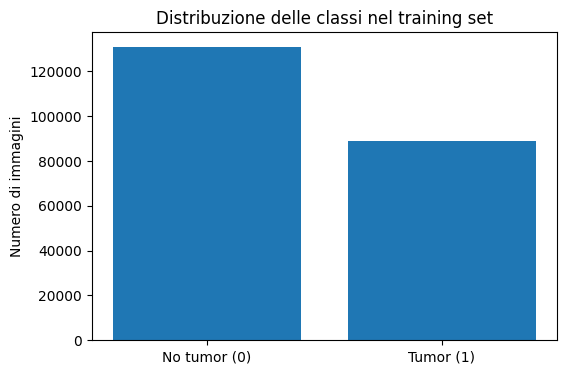

label
0    130908
1     89117
Name: count, dtype: int64
Duplicati di id: 0
Righe con label non valide: 0
Immagini nel CSV: 220025
File .tif nella cartella train: 220025
Controllo su 200 immagini -> mancanti: 0, corrotte: 0


In [3]:
label_counts = train_df["label"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(["No tumor (0)", "Tumor (1)"], label_counts.values)
plt.title("Distribuzione delle classi nel training set")
plt.ylabel("Numero di immagini")
plt.show()

print(label_counts)


n_dup = train_df["id"].duplicated().sum()
print("Duplicati di id:", n_dup)

bad_labels = train_df[~train_df["label"].isin([0, 1])]
print("Righe con label non valide:", len(bad_labels))
if len(bad_labels) > 0:
    print(bad_labels.head())


csv_count = len(train_df)
disk_count = len([f for f in os.listdir(TRAIN_DIR) if f.endswith(".tif")])
print("Immagini nel CSV:", csv_count)
print("File .tif nella cartella train:", disk_count)

# Sample-based check to quickly verify missing or corrupted images
# without significantly slowing down the notebook on the full dataset.
sample_n = 200  # piccolo così non ci mette troppo
sample_df = train_df.sample(sample_n, random_state=42)

missing = 0
corrupted = 0

for img_id in sample_df["id"]:
    path = os.path.join(TRAIN_DIR, img_id + ".tif")

    if not os.path.exists(path):
        missing += 1
        continue

    try:
        with Image.open(path) as im:
            im.verify()  # controlla che il file sia leggibile
    except Exception:
        corrupted += 1

print(f"Controllo su {sample_n} immagini -> mancanti: {missing}, corrotte: {corrupted}")


In [18]:
sample_ids = train_df.sample(200, random_state=42)["id"]

pixels = []
for img_id in sample_ids:
    img = np.array(Image.open(os.path.join(TRAIN_DIR, img_id + ".tif")))
    pixels.append(img.reshape(-1, 3))

pixels = np.vstack(pixels)
rgb_mean = pixels.mean(axis=0)
rgb_std = pixels.std(axis=0)

print("RGB mean:", rgb_mean)
print("RGB std:", rgb_std)

RGB mean: [180.76360786 142.44014703 176.77591254]
RGB std: [60.94873921 71.69789307 56.94427318]


The RGB statistics highlight substantial color variability across images, justifying the use of normalization in the preprocessing pipeline.

## EDA: Sample Images


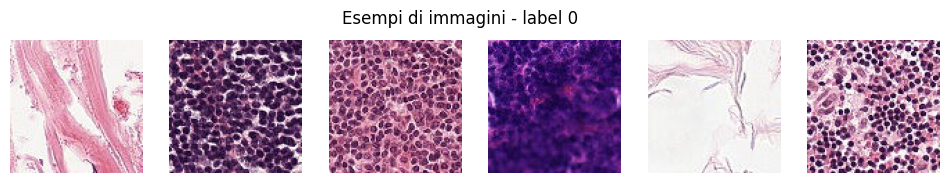

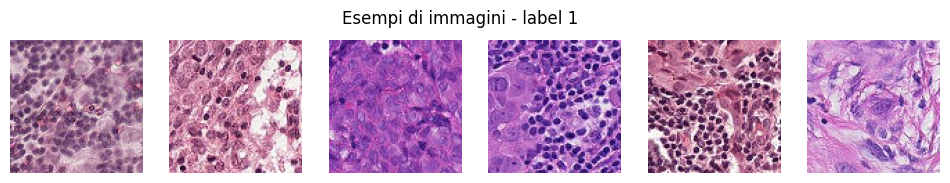

In [4]:
def show_class_samples(df, label, n=6, seed=42):
    samples = df[df["label"] == label].sample(n, random_state=seed)
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for ax, img_id in zip(axes, samples["id"]):
        img = Image.open(f"{TRAIN_DIR}/{img_id}.tif")
        ax.imshow(img)
        ax.axis("off")
    fig.suptitle(f"Esempi di immagini - label {label}")
    plt.show()

show_class_samples(train_df, label=0)
show_class_samples(train_df, label=1)


The images exhibit substantial variability in color, texture, and tissue structure.
From a visual inspection, distinguishing between tumor and non-tumor tissue is challenging,
which motivates the use of deep learning models capable of capturing subtle spatial patterns.

Regarding class distribution, the dataset shows a moderate imbalance, with approximately
130,908 negative samples and 89,117 positive samples. While the classes are not perfectly balanced,
the imbalance is not severe enough to require aggressive techniques such as downsampling or
oversampling at this stage. Instead, the use of robust evaluation metrics such as AUC-ROC is
considered sufficient to mitigate potential bias during model evaluation.


## Train/Validation Split


In [5]:
train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

print("Train size:", len(train_split))
print("Validation size:", len(val_split))
print("Train distribution:\n", train_split["label"].value_counts(normalize=True))
print("Validation distribution:\n", val_split["label"].value_counts(normalize=True))


Train size: 176020
Validation size: 44005
Train distribution:
 label
0    0.594966
1    0.405034
Name: proportion, dtype: float64
Validation distribution:
 label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


## Smaller Subset for Faster Experiments


In [6]:
train_split_small = pd.concat([
    train_split[train_split["label"] == 0].sample(5000, random_state=42),
    train_split[train_split["label"] == 1].sample(5000, random_state=42),
], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

val_split_small = pd.concat([
    val_split[val_split["label"] == 0].sample(2000, random_state=42),
    val_split[val_split["label"] == 1].sample(2000, random_state=42),
], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(train_split_small["label"].value_counts())
print(val_split_small["label"].value_counts())


label
1    5000
0    5000
Name: count, dtype: int64
label
0    2000
1    2000
Name: count, dtype: int64


Due to computational constraints (CPU training and large dataset size), a smaller subset of the training data was used to make experimentation feasible.
We sampled a balanced subset per class (5,000 negatives and 5,000 positives for training; 2,000 per class for validation).
This preserves class balance while significantly reducing training time, enabling faster iteration for model comparison and hyperparameter tuning.


## Custom Architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # blocco 1: conv -> conv -> pool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 96 -> 48

        # blocco 2: conv -> conv -> pool
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 48 -> 24

        # classifier (flatten + dense)
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 1)  # 1 logit per BCEWithLogitsLoss

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# uso: sostituisci la tua ResNet con questa
my_model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
my_optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-4)


Device: cpu


## Model Architecture: ResNet18

A ResNet18 architecture was selected due to its balance between representational
power and computational efficiency.

Due to the absence of external internet access in the execution environment,
pretrained ImageNet weights could not be downloaded. As a result, the model was
trained from scratch.

The final fully connected layer was replaced with a single-output neuron,
and the model was trained using Binary Cross Entropy with logits loss
(BCEWithLogitsLoss).


In [10]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

IMG_SIZE = 96

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
print(model.fc)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Linear(in_features=512, out_features=1, bias=True)


## Data Transforms and Dataloaders


In [11]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

class HistDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, "id"]
        y = torch.tensor(self.df.loc[idx, "label"], dtype=torch.float32)
        img = Image.open(os.path.join(self.img_dir, img_id + ".tif")).convert("RGB")
        x = self.transform(img)
        return x, y

batch_size = 16

train_loader = DataLoader(
    HistDataset(train_split_small, TRAIN_DIR, train_tfms),
    batch_size=batch_size, shuffle=True, num_workers=0
)

val_loader = DataLoader(
    HistDataset(val_split_small, TRAIN_DIR, val_tfms),
    batch_size=batch_size, shuffle=False, num_workers=0
)

x, y = next(iter(train_loader))
print(x.shape, y.shape)
print(train_split_small.head())
print(train_split_small.columns)


torch.Size([16, 3, 96, 96]) torch.Size([16])
                                         id  label
0  aac217bffe11b0c68e7851ec5b253812a8c86910      1
1  5feb9222c7c74efe21cf9ca2674f004fd5b0f967      0
2  8984c65527ca1448e9043bfa87a090c97c80c716      0
3  d1f31b552bf9cfae26532a7d5dbf3637d18e8d33      0
4  e256409cc7f0209c7689a239b492c19f129c4d4c      0
Index(['id', 'label'], dtype='object')


Note: Internet access was disabled in the Kaggle environment, so ImageNet-pretrained weights could not be downloaded.
Therefore, ResNet18 was trained from scratch. This provides a strong baseline architecture,
although transfer learning would likely improve convergence speed and performance.

## Training and Evaluation (AUC)



In [12]:
from sklearn.metrics import roc_auc_score

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).view(-1, 1)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate_auc(model, loader):
    model.eval()
    all_y = []
    all_p = []
    running_loss = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).view(-1, 1)

        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)

        probs = torch.sigmoid(logits)
        all_y.append(y.detach().cpu().numpy())
        all_p.append(probs.detach().cpu().numpy())

    all_y = np.vstack(all_y).ravel()
    all_p = np.vstack(all_p).ravel()
    auc = roc_auc_score(all_y, all_p)

    return running_loss / len(loader.dataset), auc


## Run Training


In [13]:
def run_training(model, optimizer, train_loader, val_loader, n_epochs, best_path):
    history = {"train_loss": [], "val_loss": [], "val_auc": []}
    best_auc = -1.0

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_auc = evaluate_auc(model, val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_auc"].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), best_path)

        print(f"Epoch {epoch}/{n_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f} | best_auc={best_auc:.4f}")

    results_df = pd.DataFrame({
        "epoch": list(range(1, n_epochs+1)),
        "train_loss": history["train_loss"],
        "val_loss": history["val_loss"],
        "val_auc": history["val_auc"],
    })
    return best_auc, results_df


In [14]:
n_epochs = 3

# ResNet18
print("\n=== Training ResNet18 ===")
resnet_best_auc, resnet_df = run_training(
    model, optimizer, train_loader, val_loader, n_epochs, best_path="best_resnet18.pt"
)

# SimpleCNN
print("\n=== Training SimpleCNN ===")
cnn_best_auc, cnn_df = run_training(
    my_model, my_optimizer, train_loader, val_loader, n_epochs, best_path="best_simplecnn.pt"
)

# Tabella confronto (minimo per rubrica)
compare_df = pd.DataFrame([
    {"model": "ResNet18", "best_val_auc": resnet_best_auc, "epochs": n_epochs, "lr": 1e-4, "batch_size": batch_size},
    {"model": "SimpleCNN", "best_val_auc": cnn_best_auc, "epochs": n_epochs, "lr": 1e-4, "batch_size": batch_size},
])
compare_df



=== Training ResNet18 ===
Epoch 1/3 | train_loss=0.4915 | val_loss=0.4025 | val_auc=0.9051 | best_auc=0.9051
Epoch 2/3 | train_loss=0.4139 | val_loss=0.4372 | val_auc=0.8931 | best_auc=0.9051
Epoch 3/3 | train_loss=0.3303 | val_loss=0.4264 | val_auc=0.8885 | best_auc=0.9051

=== Training SimpleCNN ===
Epoch 1/3 | train_loss=0.5133 | val_loss=0.4691 | val_auc=0.8639 | best_auc=0.8639
Epoch 2/3 | train_loss=0.4509 | val_loss=0.4644 | val_auc=0.8976 | best_auc=0.8976
Epoch 3/3 | train_loss=0.4188 | val_loss=0.3985 | val_auc=0.9027 | best_auc=0.9027


,model,best_val_auc,epochs,lr,batch_size
0,ResNet18,0.905149,3,0.0001,16
1,SimpleCNN,0.902668,3,0.0001,16


The model achieves its best validation AUC after the first epoch. In subsequent epochs, training loss continues to decrease while validation AUC degrades, indicating early overfitting. This happens because the model is trained from scratch on a relatively small subset of the dataset and without strong data augmentation, so it can fit training-specific patterns quickly but generalize less well to the validation set. Therefore, the checkpoint corresponding to the maximum validation AUC is selected as the final model.

The SimpleCNN shows a slower and more stable improvement in validation AUC across epochs, reaching its best performance at the final epoch. This is consistent with its lower model capacity, which reduces early overfitting but limits overall performance compared to ResNet18. The best checkpoint is selected based on the maximum validation AUC.

ResNet18 -> best epoch: 1 | best val AUC: 0.9051
SimpleCNN -> best epoch: 3 | best val AUC: 0.9027


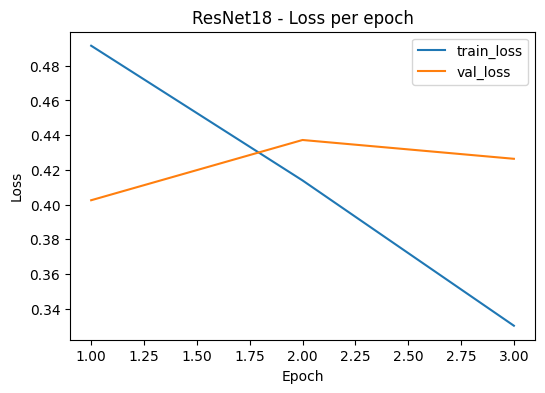

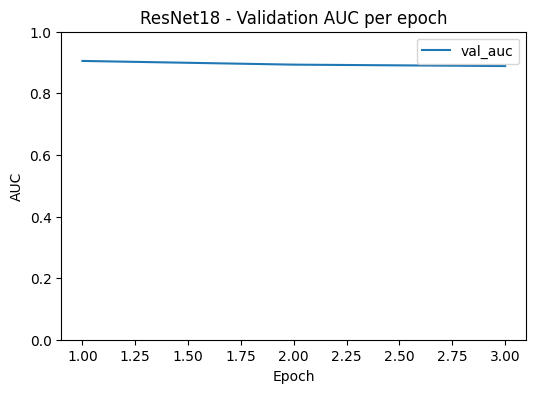

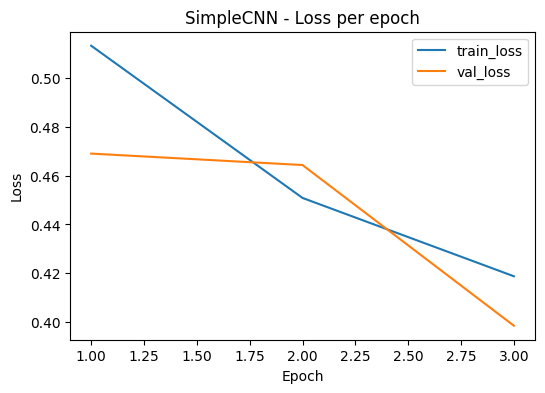

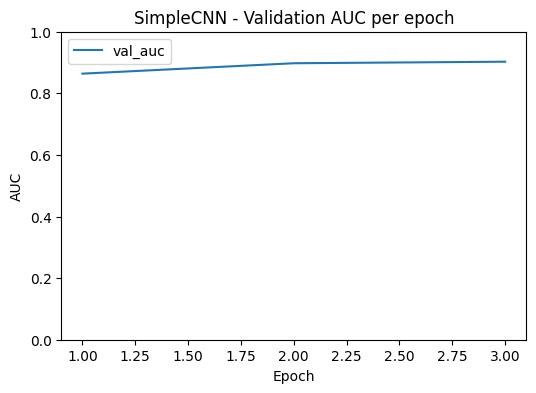

In [16]:
def best_epoch_info(df, name):
    best_row = df.loc[df["val_auc"].idxmax()]
    best_epoch = int(best_row["epoch"])
    best_auc = float(best_row["val_auc"])
    print(f"{name} -> best epoch: {best_epoch} | best val AUC: {best_auc:.4f}")
    return best_epoch, best_auc


resnet_best_epoch, resnet_best_auc_from_df = best_epoch_info(resnet_df, "ResNet18")
cnn_best_epoch, cnn_best_auc_from_df = best_epoch_info(cnn_df, "SimpleCNN")

# Plot ResNet18
plt.figure(figsize=(6,4))
plt.plot(resnet_df["epoch"], resnet_df["train_loss"], label="train_loss")
plt.plot(resnet_df["epoch"], resnet_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 - Loss per epoch")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(resnet_df["epoch"], resnet_df["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("ResNet18 - Validation AUC per epoch")
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot SimpleCNN
plt.figure(figsize=(6,4))
plt.plot(cnn_df["epoch"], cnn_df["train_loss"], label="train_loss")
plt.plot(cnn_df["epoch"], cnn_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN - Loss per epoch")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(cnn_df["epoch"], cnn_df["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("SimpleCNN - Validation AUC per epoch")
plt.ylim(0, 1)
plt.legend()
plt.show()


## Results and Analysis

ResNet18 converges quickly, reaching its best validation performance after the first epoch (validation AUC ≈ 0.905). In later epochs, training loss continues to decrease while validation AUC drops, indicating early overfitting. This happens because the model is trained from scratch on a relatively small subset of the dataset and without strong data augmentation, so it can fit training-specific patterns quickly but generalize less well to the validation set. Therefore, the checkpoint corresponding to the maximum validation AUC (saved during training) is selected as the final ResNet18 model.

For the custom SimpleCNN, validation AUC improves more gradually across epochs and reaches its best value at the final epoch (validation AUC ≈ 0.903). This suggests slower overfitting due to the lower-capacity architecture. Overall, SimpleCNN performs slightly below ResNet18 on this split, so the best overall model is the ResNet18 checkpoint with maximum validation AUC.


Selected: ResNet18 | best_epoch=1 | best_val_auc=0.9051 | checkpoint=best_resnet18.pt


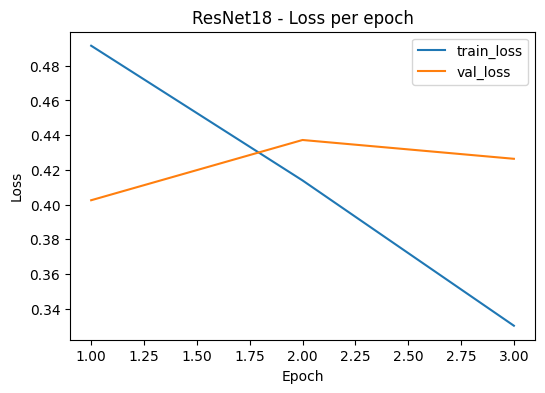

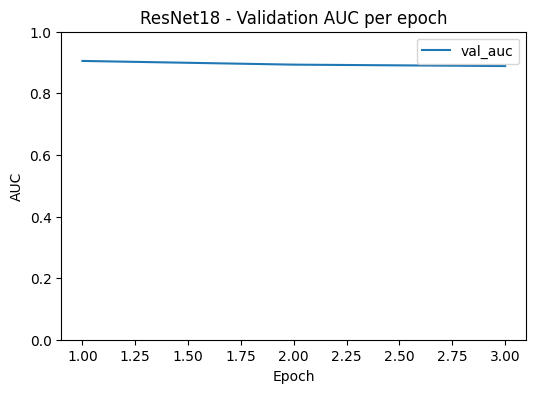

Loaded best model from: best_resnet18.pt | best_auc: 0.905149


In [17]:
# --- Select best model + history for plots ---
if resnet_best_auc >= cnn_best_auc:
    best_model = model
    best_name = "ResNet18"
    best_path = "best_resnet18.pt"
    results_df = resnet_df
else:
    best_model = my_model
    best_name = "SimpleCNN"
    best_path = "best_simplecnn.pt"
    results_df = cnn_df

best_row = results_df.loc[results_df["val_auc"].idxmax()]
best_epoch = int(best_row["epoch"])
best_auc = float(best_row["val_auc"])

print(f"Selected: {best_name} | best_epoch={best_epoch} | best_val_auc={best_auc:.4f} | checkpoint={best_path}")

# --- Plots for the selected model ---
plt.figure(figsize=(6,4))
plt.plot(results_df["epoch"], results_df["train_loss"], label="train_loss")
plt.plot(results_df["epoch"], results_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{best_name} - Loss per epoch")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(results_df["epoch"], results_df["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title(f"{best_name} - Validation AUC per epoch")
plt.ylim(0, 1)
plt.legend()
plt.show()

# --- Load best checkpoint into the correct model ---
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()
print("Loaded best model from:", best_path, "| best_auc:", best_auc)


## Create Submission (test set predictions)


In [ ]:
if resnet_best_auc >= cnn_best_auc:
    best_model = model
    best_path = "best_resnet18.pt"
    best_name = "ResNet18"
else:
    best_model = my_model
    best_path = "best_simplecnn.pt"
    best_name = "SimpleCNN"

best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()
print("Best model selected:", best_name, "| loaded:", best_path)

# Dataset + loader test (come prima)
class HistTestDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, "id"]
        img = Image.open(os.path.join(self.img_dir, img_id + ".tif")).convert("RGB")
        x = self.transform(img)
        return img_id, x

test_loader = DataLoader(
    HistTestDataset(sub_df, TEST_DIR, val_tfms),
    batch_size=64, shuffle=False, num_workers=0
)

pred_ids = []
pred_probs = []

with torch.no_grad():
    for ids, x in test_loader:
        x = x.to(device)
        logits = best_model(x)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        pred_ids.extend(ids)
        pred_probs.extend(probs)

submission = pd.DataFrame({"id": pred_ids, "label": pred_probs})
submission.to_csv("submission.csv", index=False)
submission.head()


Best model selected: ResNet18 | loaded: best_resnet18.pt


## Conclusion

This project demonstrates that convolutional neural networks can learn meaningful representations for histopathologic cancer detection even under strict computational constraints.

What helped: The ResNet18 architecture outperformed the custom CNN, and selecting the final model based on maximum validation AUC helped mitigate early overfitting.

Limitations: Training from scratch on a reduced dataset, limited data augmentation, and CPU-only training led to early overfitting and constrained overall performance.

Future work: Performance could be improved by using ImageNet-pretrained weights, stronger data augmentation, longer training, and learning rate scheduling.
